In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout

In [19]:
#generators
train_ds=keras.utils.image_dataset_from_directory(
    directory = '/kaggle/input/dogs-vs-cats/train',
    labels= 'inferred',
    label_mode= 'int',
    batch_size= 32,
    image_size=(150,150)
)
validation_ds=keras.utils.image_dataset_from_directory(
    directory = '/kaggle/input/dogs-vs-cats/test',
    labels= 'inferred',
    label_mode= 'int',
    batch_size= 32,
    image_size=(150,150)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [36]:
# Extract images and labels from the validation dataset
X_test = []
y_test = []

for images, labels in validation_ds:
    X_test.append(images)
    y_test.append(labels)

# Convert lists to tensors
X_test = tf.concat(X_test, axis=0)
y_test = tf.concat(y_test, axis=0)


In [4]:
#Normalize
import tensorflow as tf
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [21]:
from keras.applications.vgg16 import VGG16
conv_base=VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)

In [22]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
#training only the Fc layer
conv_base.trainable=False

In [30]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False
    
for layer in conv_base.layers:
    print(layer.name,layer.trainable)

input_layer_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [23]:
model=Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [25]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [10]:
# # create lenet-5 CNN model

# model = Sequential()

# model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

# model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

# model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

# model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

# model.add(Flatten())

# model.add(Dense(128,activation='relu',kernel_regularizer=tensorflow.keras.regularizers.l2(0.05)))
# model.add(Dropout(0.1))
# model.add(Dense(64,activation='relu',kernel_regularizer=tensorflow.keras.regularizers.l2(0.05)))
# model.add(Dropout(0.1))
# model.add(Dense(1,activation='sigmoid',kernel_regularizer=tensorflow.keras.regularizers.l2(0.05)))

In [ ]:
'''
model.add(Dense(128,activation='relu',kernel_regulerizer=tensorflow.keras.regularizer.l2(0.05)))


'''

In [26]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [27]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [28]:
callback=keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [29]:
history = model.fit(train_ds,epochs=100,validation_data=validation_ds,callbacks=callback)

Epoch 1/100


I0000 00:00:1725347020.799247     109 service.cc:145] XLA service 0x7f5a4c0051e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725347020.799300     109 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725347020.799303     109 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  3/625 ━━━━━━━━━━━━━━━━━━━━ 42s 68ms/step - accuracy: 0.5677 - loss: 20.8297 

I0000 00:00:1725347030.701851     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 70s 93ms/step - accuracy: 0.9113 - loss: 1.6223 - val_accuracy: 0.9532 - val_loss: 0.1299
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 87ms/step - accuracy: 0.9694 - loss: 0.0799 - val_accuracy: 0.9490 - val_loss: 0.1475
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 88ms/step - accuracy: 0.9799 - loss: 0.0564 - val_accuracy: 0.9462 - val_loss: 0.1920
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 88ms/step - accuracy: 0.9844 - loss: 0.0486 - val_accuracy: 0.9508 - val_loss: 0.2076
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 88ms/step - accuracy: 0.9892 - loss: 0.0320 - val_accuracy: 0.9424 - val_loss: 0.2661
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 88ms/step - accuracy: 0.9891 - loss: 0.0345 - val_accuracy: 0.9468 - val_loss: 0.2621
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 88ms/step - accuracy: 0.9939 - loss: 0.0179 - val_accuracy: 0.9502 - val_loss: 0.2696
Epoch 8/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 88ms/step - accuracy: 0.9941 - loss: 0.0193 - val_

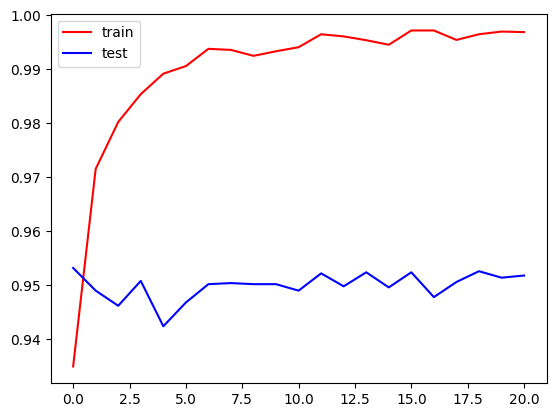

In [34]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='test')
plt.legend()
plt.show()

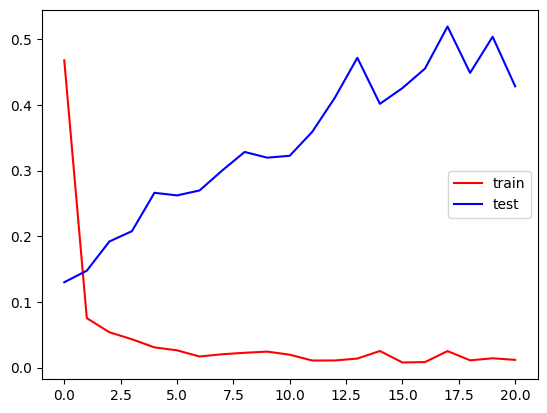

In [33]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='test')
plt.legend()
plt.show()

In [37]:
model.evaluate(X_test,y_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.9510 - loss: 0.4028


[0.428158164024353, 0.9517999887466431]

In [56]:
import cv2

test_img = cv2.imread('/kaggle/input/mydataset/cat.jpg')

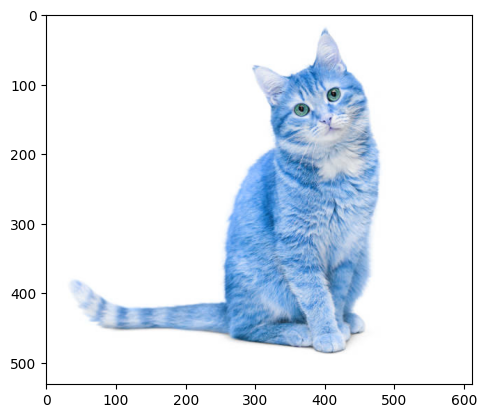

In [57]:
plt.imshow(test_img)

In [58]:
test_img.shape

(531, 612, 3)

In [59]:
test_img = cv2.resize(test_img,(150,150))

In [60]:
test_input = test_img.reshape(-1,150,150,3)

In [61]:
model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


array([[1.0429735e-23]], dtype=float32)